In [40]:
#1D non-isothermal

'''
 - Its just 1D so maybe we can take out the pi
 - I think I just have to do a complete sweep and see if the system does not build up moles anywhere DOUBLE CHECK THE MASS BALANCE TO SEE IF WE ARE NOT DIVIDING 2/2

- finish my paper 
- finish 2D

- Modeling to be done with electrolyzer
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    dH_Ar = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar], [dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar]

In [42]:
#tryint to match some table with my equations
#Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Ar
_, _, Cps, htest = heats(400)
print(htest)
print(Cps[3]*(400-298))

'''Try the forming it at 298.15 first and then breaking it again. If that doesnt work, then use absolute ones
https://www.youtube.com/watch?v=g_XBp-6BJP4
https://engineering.wayne.edu/mechanical/pdfs/thermodynamic-_tables-updated.pdf
https://www.govinfo.gov/content/pkg/GOVPUB-C13-c19f48b42b2c70c3422cda30d301b8b2/pdf/GOVPUB-C13-c19f48b42b2c70c3422cda30d301b8b2.pdf
'''

10.018
13.888

[3.86029491653332, 3.452159561333332, 2.974776901600009, 4.00251225013335, 2.959149521066667, 2.1170501110878526]
4216.294854936


13.888

In [43]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constant
L = 0.0609 #m
R_inner = 0.00225 #m outside diameter of inner tube
R_outer = 0.0035 #m inside diameter of outer tube

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
Souter = 2*np.pi*R_outer*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)

print(A)

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tin = 900 #K
P = 1 #bar or atm
Rgas = 8.3144598 * 10**-5

sccm0 = np.array([16.16, 43.04, 10, 10, 0, 0]) #I GOT RID OF Ar BECAUSE I CANT FIND ANY THING FOR THAT
mols0 = sccm0/22400 * 273 / Tin * P / 1 / 60
boundary = np.concatenate((mols0, [Tin]))
print(boundary)

#rate equation constants
Rreact = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 0

I = 9 #curent in Amps
F = 96485 #faradays constant

Uouter = 18.6 #J (s K m2)^-1.     Uouter = 0.116/Souter
Ts = 298 #K

q_furn = 22500 #W/m2 #16000*Souter #J/s  q_furn= 2

print(q_furn)
print(Souter*Uouter*(-1600 + Ts))
print(q_furn + Uouter*(-1400 + Ts))
MM = np.array([16.04, 18.01528, 28.01, 44.009, 2.016, 39.948])
m0 = np.dot(MM, mols0)
print(m0) #kg/s


2.2580197197676646e-05
[3.64722222e-06 9.71388889e-06 2.25694444e-06 2.25694444e-06
 0.00000000e+00 0.00000000e+00 9.00000000e+02]
22500
-32.43315023536244
2002.7999999999993
0.0003960427546111111


In [44]:
x_num = 100000
dz = L/(x_num-1)

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[0, :] = boundary[0]
init_guess[1, :] = boundary[1]
init_guess[2, :] = boundary[2]
init_guess[3, :] = boundary[3]
init_guess[4, :] = boundary[4]  
init_guess[5, :] = boundary[5]
init_guess[6, :] = np.linspace(Tin,1000,x_num)

def odes(x, F): #dy/dt = f(x)
    F[:6, :][F[:6, :] < 0] = 0
    y = F[:6]/np.sum(F[:6], axis = 0)
    T = F[6]
    Ctot = P/(Rgas * T)

    global vfinal
    vfinal = np.sum(F[:6,:]/A, axis = 0)/Ctot[:] #m3/sec

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)

    rsmr = np.full(len(T), 0.1) #2*np.pi*R_outer/A*Ku*Asmr*np.exp(-Easmr*1000/Rreact/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
    rwgs = np.full(len(T), 0) #2*np.pi*R_outer/A*Ku*Awgs*np.exp(-Eawgs*1000/Rreact/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
    #rh2r = I/(2*F*L) #have not confirmed if this is correct

    dHsmr, dHwgs, Cps, _ = heats(T)

    Cpg = np.sum(y[:6, :]*Cps, axis=0)

    ch4 = (-rsmr)*A
    h2o = (-rsmr - rwgs)*A
    co = (rsmr - rwgs)*A
    co2 = (rwgs)*A
    h2 = (3*rsmr + rwgs)*A      # + h2Removal*rh2r
    ar = np.zeros(len(T))
    # print(len(T[hnx:endnx]))
    # print(len(T[:hnx][::-1]))
    Temp = (Souter/V*Uouter*(-T + Ts)  #this heat balance is for sure wrong
                - V*(dHsmr*rsmr + dHwgs*rwgs) 
                + q_furn*Souter/V)/(np.sum(F[:6,5], axis = 0)/A*Cpg) #I changed this to 5 so change it back to all and see if it changes

    return np.vstack([ch4, h2o, co, co2, h2, ar, Temp])

def bcs(yleft, yright):
    return np.array(yleft-boundary)

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.000000001)

Text(0.5, 1.0, 'Temperature profile with Tin = 900K')

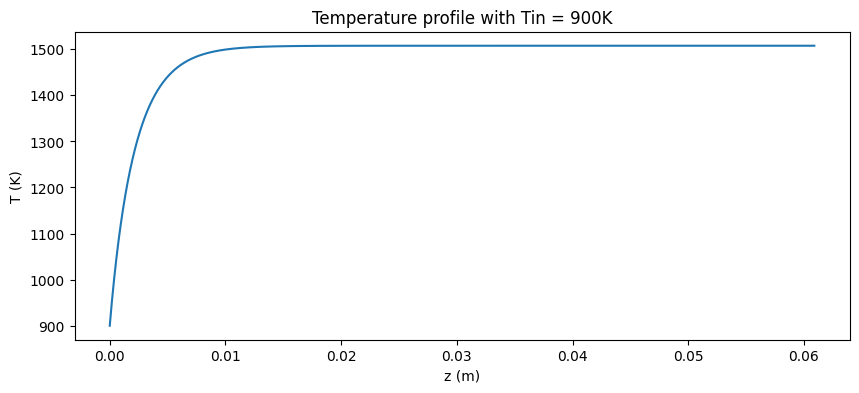

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(soln.x, soln.y[6])
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title(f'Temperature profile with Tin = {Tin}K')

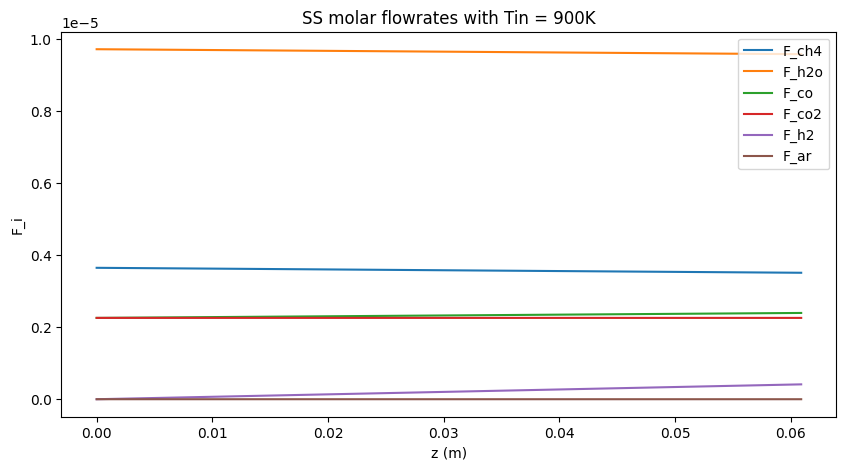

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(soln.x, soln.y[0], label='F_ch4')
plt.plot(soln.x, soln.y[1], label='F_h2o')
plt.plot(soln.x, soln.y[2], label='F_co')
plt.plot(soln.x, soln.y[3], label='F_co2')
plt.plot(soln.x, soln.y[4], label='F_h2')
plt.plot(soln.x, soln.y[5], label='F_ar')
plt.xlabel('z (m)')
plt.ylabel('F_i')
plt.title(f'SS molar flowrates with Tin = {Tin}K')
plt.legend()

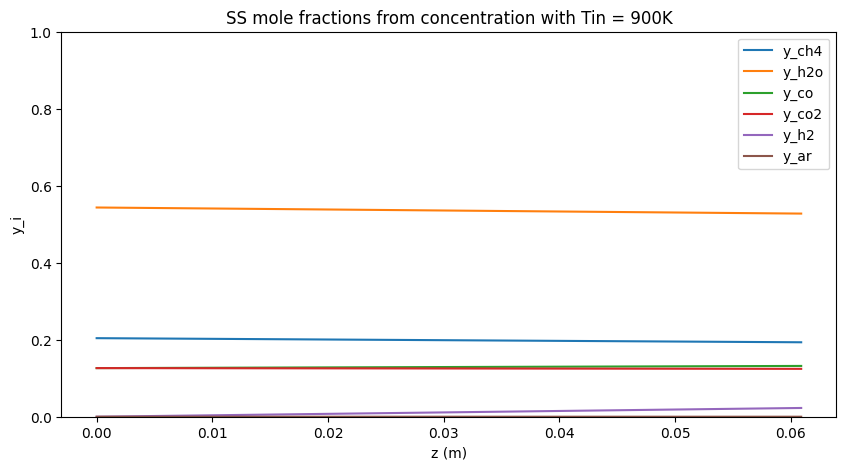

In [47]:
#mole fraction calculation
yplot = soln.y[:6]/np.sum(soln.y[:6], axis = 0)
plt.figure(figsize=(10, 5))
plt.plot(soln.x, yplot[0], label='y_ch4')
plt.plot(soln.x, yplot[1], label='y_h2o')
plt.plot(soln.x, yplot[2], label='y_co')
plt.plot(soln.x, yplot[3], label='y_co2')
plt.plot(soln.x, yplot[4], label='y_h2')
plt.plot(soln.x, yplot[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z (m)')
plt.ylabel('y_i')
plt.title(f'SS mole fractions from concentration with Tin = {Tin}K')
plt.legend()

99999
100000


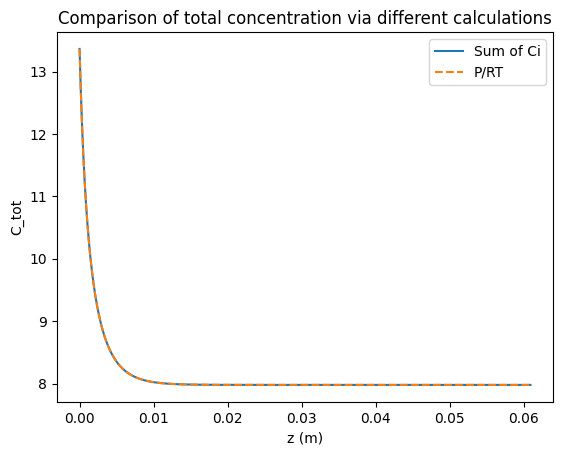

In [48]:
u = vfinal*A #this part is a little ugly but whatever
print(len(u))
print(len(soln.y[0]))
Csum = np.sum(soln.y[:6,:len(u)], axis = 0)/u

T = soln.y[6]
plt.plot(soln.x[:len(Csum)], Csum, label='Sum of Ci')
plt.plot(soln.x, P/(Rgas * T), label='P/RT', linestyle='--')
plt.xlabel('z (m)')
plt.ylabel('C_tot')
plt.title(f'Comparison of total concentration via different calculations')
plt.legend()

In [49]:
mf = np.dot(MM, soln.y[:6,-1])

print(f'{m0:.4e}')
print(f'{mf:.4e}')
print(f'mass balance off by {abs(mf - m0)/mf *100:.2}%')

3.9604e-04
3.9604e-04
mass balance off by 9.4e-05%


In [50]:
#Calculating heat loss to surr and heat balance with heats of formation
smr, _, _, _ = heats(1500)
print(smr)
qsurr2 = np.sum(Uouter*dz*2*np.pi*R_outer*(-soln.y[6,:]+Ts))
print(qsurr2)
Q = q_furn*Souter + qsurr2 - 0.1*227506*V
print(Q) #W

# dH = Q. need to figure out dH 
# H = dh + standard heat of formation
# and then see if they match
_, _, _, heatsin = heats(soln.y[6,0]) #kJ/mol
_, _, _, heatsout = heats(soln.y[6,-1]) #kJ/mol

#[dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar] # kJ/mol
print(heatsin + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))
Hin = np.sum((heatsin + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))*10**3 *soln.y[:6,0])
Hout = np.sum((heatsout + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))*10**3 *soln.y[:6,-1])
dH = Hout-Hin
print(dH) #W

print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

227506.65905729163
-29.578091660868452
0.5239945504085906
[ -43.29513842 -219.86081076  -92.10049398 -365.48821493   17.6761085
   12.51005012]
0.5867770875562206
0.587 W
0.524 W
heat balance off by 11.98%


In [51]:
#heat balance with the absolute heats of formation
qsurr2 = np.sum(Uouter*dz*2*np.pi*R_outer*(-soln.y[6,:]+Ts))
print(qsurr2)
Q = q_furn*Souter + qsurr2
print(Q) #W

#hydrogen calculation: 1804.09 btu/lb * 2.326 j/g / btu/lb * 2 g/mol 
#print(1804.09*2.326*2/1000)

# dH = Q. need to figure out dH 
# H = dh + standard heat of formation
# and then see if they match
_, _, _, heatsin = heats(soln.y[6,0]) #kJ/mol
_, _, _, heatsout = heats(soln.y[6,-1]) #kJ/mol

#[dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar] # kJ/mol
print(heatsin + np.array([9.857, 9.904, 8.669, 9.364, 8.393, 0]))
Hin = np.sum((heatsin + np.array([9.857, 9.904, 8.669, 9.364, 8.393, 0]))*10**3 *soln.y[:6,0])
Hout = np.sum((heatsout + np.array([9.857, 9.904, 8.669, 9.364, 8.393, 0]))*10**3 *soln.y[:6,-1])
dH = Hout-Hin
print(dH) #W

print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

-29.578091660868452
0.5552796742014472
[41.06186158 31.84318924 27.06850602 37.39578507 26.0691085  12.51005012]
0.5604139809229818
0.56 W
0.555 W
heat balance off by 0.9246%


Text(0.5, 1.0, 'Velocity profile along reactor')

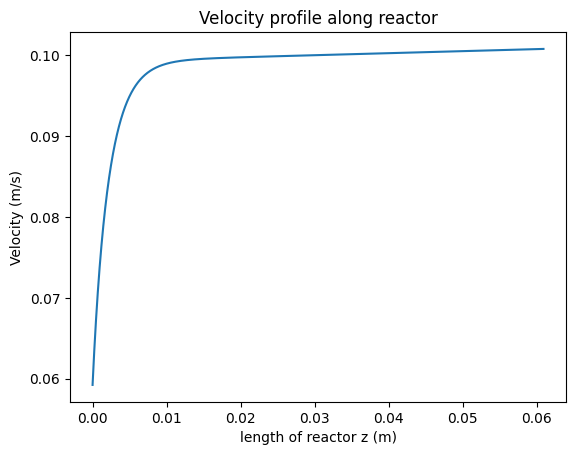

In [52]:
v = vfinal
plt.plot(soln.x[:len(v)], v)
plt.xlabel('length of reactor z (m)')
plt.ylabel('Velocity (m/s)')
plt.title(f'Velocity profile along reactor')